In [1]:
import os
import glob

import GPRutils
import DESutils
import vK2KGPR

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

exps = DESutils.findExpNums()
gband = DESutils.bandDict["g"]
rband = DESutils.bandDict["r"]
iband = DESutils.bandDict["i"]
zband = DESutils.bandDict["z"]

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
expNum = exps[0]

In [3]:
dC = GPRutils.loadFITS(f"/home/fortino/GPRSolutions/simple/GPR.{expNum}.?RC.fits")
dC.summarize(noplots=True)

fitCorrParams = dC.fitCorrParams.copy()
finalParams = dC.params.copy()

Exposure: 348819
Band: z
Kernel Parameters from 2d Correlation Fitting
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     

Kernel Parameters from GPR Optimization
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      

Jackknifed xi+ (Inter-set pairs excluded)
xi0: 83.083 ± 1.693 mas^2
xif: 5.641 ± 0.486 mas^2
Reduction: 14.729



In [15]:
def printXi(dC):
    GPRutils.printParams(dC.params)
    xi0, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xi0: {xi0:.3f} ± {xierr:.3f} mas^2")
    
    xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xif: {xif:.3f} ± {xierr:.3f} mas^2")
    print(f"Reduction: {xi0/xif:.3f}")
    print()

In [5]:
# Get xi for final params

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(finalParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 7.377 ± 1.337 mas^2
Reductin: 11.105



In [17]:
# Get xi for fitCorr params

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(fitCorrParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.289 ± 1.523 mas^2
Reduction: 6.667



In [6]:
# Test fitCorr OS effect on final params
testParams = np.array([
    finalParams[0],
    fitCorrParams[1],
    finalParams[2],
    finalParams[3],
    finalParams[4]
])

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(testParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

220.7504306    1.5349095      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 7.398 ± 1.331 mas^2
Reductin: 11.074



In [7]:
# Test OS effect on final params
OS0 = fitCorrParams[1]
OSf = finalParams[1]
N = 25
OSList = np.linspace(0, 2*OSf, N)
paramList = np.array([finalParams]*N)
paramList[:, 1] = OSList

xiList= []
xierrList = []
for params in paramList:
    GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
    try:
        GP.fit(params)
        GP.predict(dC.Xvalid)
    except np.linalg.LinAlgError:
        xiList.append(0)
        xierrList.append(0)
        print(f"oS: {params[1]:.3f}. LinAlgError")
        continue
    xi, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"oS: {params[1]:.3f}. xif: {xi:.3f} ± {xierr:.3f} mas^2")

    xiList.append(xi)
    xierrList.append(xierr)

oS: 0.000. LinAlgError
oS: 0.048. xif: 55.400 ± 3.809 mas^2
oS: 0.097. xif: 35.514 ± 2.821 mas^2
oS: 0.145. xif: 21.782 ± 2.031 mas^2
oS: 0.194. xif: 14.077 ± 1.618 mas^2
oS: 0.242. xif: 10.358 ± 1.449 mas^2
oS: 0.291. xif: 8.693 ± 1.384 mas^2
oS: 0.339. xif: 7.962 ± 1.359 mas^2
oS: 0.388. xif: 7.638 ± 1.348 mas^2
oS: 0.436. xif: 7.491 ± 1.343 mas^2
oS: 0.485. xif: 7.424 ± 1.340 mas^2
oS: 0.533. xif: 7.392 ± 1.338 mas^2
oS: 0.582. xif: 7.377 ± 1.337 mas^2
oS: 0.630. xif: 7.371 ± 1.336 mas^2
oS: 0.679. xif: 7.369 ± 1.336 mas^2
oS: 0.727. xif: 7.368 ± 1.335 mas^2
oS: 0.776. xif: 7.369 ± 1.335 mas^2
oS: 0.824. xif: 7.370 ± 1.334 mas^2
oS: 0.873. xif: 7.372 ± 1.334 mas^2
oS: 0.921. xif: 7.374 ± 1.333 mas^2
oS: 0.970. xif: 7.376 ± 1.333 mas^2
oS: 1.018. xif: 7.378 ± 1.333 mas^2
oS: 1.067. xif: 7.380 ± 1.333 mas^2
oS: 1.115. xif: 7.382 ± 1.332 mas^2
oS: 1.164. xif: 7.384 ± 1.332 mas^2


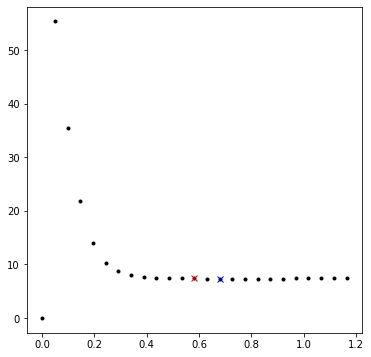

In [13]:
plt.figure(figsize=(6, 6))
plt.plot(OSList, xiList, "k.")
plt.plot(finalParams[1], xif, "rx")
plt.plot(OSList[np.argmin(xiList[1:])], np.min(xiList[1:]), "bx")

In [14]:
# Test fitCorr OS and K effect on final params
testParams = np.array([
    fitCorrParams[0],
    fitCorrParams[1],
    finalParams[2],
    finalParams[3],
    finalParams[4]
])

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(testParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

109.1565559    1.5349095      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 8.157 ± 1.344 mas^2
Reductin: 10.044



In [16]:
# Test fitCorr OS, K, and d effect on final params
testParams = np.array([
    fitCorrParams[0],
    fitCorrParams[1],
    fitCorrParams[2],
    finalParams[3],
    finalParams[4]
])

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(testParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

109.1565559    1.5349095      -0.0061141     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 8.275 ± 1.348 mas^2
Reduction: 9.901



In [18]:
params

array([ 2.20750431e+02,  1.16350891e+00, -8.45066151e-03,  1.22671459e-02,
       -3.07480046e-02])